# **Sentiment Analysis Ulasan Aplikasi Mobile Legends: Bang Bang di Google Play Store**

Proyek ini bertujuan untuk melakukan analisis sentimen pada ulasan pengguna aplikasi `Mobile Legends: Bang Bang` yang diperoleh dari Google Play Store. Proses ini mencakup pengumpulan data secara mandiri melalui web scraping, ekstraksi fitur, pelabelan data, serta pelatihan model machine learning atau deep learning untuk mengklasifikasikan sentimen ulasan ke dalam tiga kategori: `positif`, `negatif`, dan `netral`.

## **Goals**
- Memberikan insight kepada pengembang Mobile Legends mengenai kepuasan pengguna.
- Membantu pemain memahami isu-isu utama yang sering dibahas dalam ulasan.
- Mengembangkan model analisis sentimen berbasis NLP dengan akurasi tinggi.

## **Import Library**

In [32]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import joblib
import os

# Text processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Set random seeds for reproducibility
np.random.seed(1234)
tf.random.set_seed(1234)

# Download required NLTK resources
nltk.data.path.append("d:/Coolyeah/Dicoding/Submission_Dicoding/ml_ops/envs/ml-pengembangan/nltk_data")
nltk.download('punkt', download_dir="d:/Coolyeah/Dicoding/Submission_Dicoding/ml_ops/envs/ml-pengembangan/nltk_data")
nltk.download('stopwords', download_dir="d:/Coolyeah/Dicoding/Submission_Dicoding/ml_ops/envs/ml-pengembangan/nltk_data")
nltk.download('punkt_tab', download_dir="d:/Coolyeah/Dicoding/Submission_Dicoding/ml_ops/envs/ml-pengembangan/nltk_data")

[nltk_data] Downloading package punkt to
[nltk_data]     d:/Coolyeah/Dicoding/Submission_Dicoding/ml_ops/envs/m
[nltk_data]     l-pengembangan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     d:/Coolyeah/Dicoding/Submission_Dicoding/ml_ops/envs/m
[nltk_data]     l-pengembangan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     d:/Coolyeah/Dicoding/Submission_Dicoding/ml_ops/envs/m
[nltk_data]     l-pengembangan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## **Read Dataset**

In [5]:
df = pd.read_csv('mlbb_reviews.csv')
df.head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent
0,Pengguna Google,ini game bagus sih tapi tolong ya developer hp...,5,0,1.9.64.10601,2025-03-21 17:55:28,NaN
1,Pengguna Google,game burik jangan di mainin,1,0,1.9.64.10601,2025-03-21 17:52:55,NaN
2,Pengguna Google,"game yg sangat ramah, sangat cocok game ini bu...",5,0,1.9.64.10601,2025-03-21 17:52:36,NaN
3,Pengguna Google,kapan skin sanrio liris moonton?,2,0,NaN,2025-03-21 17:49:17,NaN
4,Pengguna Google,sering update jadi rada hampir abis memori hp,4,0,1.9.47.10372,2025-03-21 17:48:47,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              10000 non-null  object
 1   content               10000 non-null  object
 2   score                 10000 non-null  int64 
 3   thumbsUpCount         10000 non-null  int64 
 4   reviewCreatedVersion  6615 non-null   object
 5   at                    10000 non-null  object
 6   replyContent          279 non-null    object
dtypes: int64(2), object(5)
memory usage: 547.0+ KB


## **Check Missing Values**

In [7]:
print("\nMissing values dalam dataset:")
print(df.isnull().sum())


Missing values dalam dataset:
userName                   0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    3385
at                         0
replyContent            9721
dtype: int64


In [8]:
df["reviewCreatedVersion"] = df["reviewCreatedVersion"].fillna("Unknown")
df["replyContent"] = df["replyContent"].fillna("No Reply")

In [9]:
print(df.isnull().sum())

userName                0
content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
replyContent            0
dtype: int64


## **Labeling Sentiment**

In [10]:
positive_words = set(['bagus', 'seru', 'keren', 'suka', 'mantap', 'hebat', 'menarik', 'puas', 'lancar', 'keren'])
negative_words = set(['buruk', 'jelek', 'lambat', 'bug', 'error', 'sulit', 'mengecewakan', 'bosan', 'lag', 'crash', 'dark system', 'poke', 'pokemon', 'ayam'])

def preprocess_text(text):
    """Membersihkan teks untuk analisis sentimen."""
    if pd.isna(text):  # Cek NaN
        return ""
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Hapus karakter non-alfabet
    tokens = word_tokenize(text)  # Tokenisasi
    return tokens

def label_sentiment(text):
    """Memberikan label sentimen berdasarkan lexicon."""
    tokens = preprocess_text(text)
    score = sum(1 if token in positive_words else -1 if token in negative_words else 0 for token in tokens)
    return 'positif' if score > 0 else 'negatif' if score < 0 else 'netral'

In [11]:
df['Label Sentimen'] = df['content'].apply(label_sentiment)
df.head()

,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,Label Sentimen
0,Pengguna Google,ini game bagus sih tapi tolong ya developer hp...,5,0,1.9.64.10601,2025-03-21 17:55:28,No Reply,positif
1,Pengguna Google,game burik jangan di mainin,1,0,1.9.64.10601,2025-03-21 17:52:55,No Reply,netral
2,Pengguna Google,"game yg sangat ramah, sangat cocok game ini bu...",5,0,1.9.64.10601,2025-03-21 17:52:36,No Reply,positif
3,Pengguna Google,kapan skin sanrio liris moonton?,2,0,Unknown,2025-03-21 17:49:17,No Reply,netral
4,Pengguna Google,sering update jadi rada hampir abis memori hp,4,0,1.9.47.10372,2025-03-21 17:48:47,No Reply,netral


## **Text Preprocessing**

In [12]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize

def preprocess_text_model(text):
    """Membersihkan teks untuk pemodelan NLP."""
    if pd.isna(text): 
        return ""
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Hapus karakter non-alfabet
    tokens = word_tokenize(text)  # Tokenisasi
    return ' '.join(tokens)  # Gabungkan kembali token menjadi teks

print("Melakukan preprocessing teks untuk pemodelan...")
df['Processed_Text'] = df['content'].apply(preprocess_text_model)
print("Preprocessing teks selesai!")

print("\nContoh teks setelah preprocessing:")
for i in range(3):
    print(f"Original: {df['content'].iloc[i]}")
    print(f"Processed: {df['Processed_Text'].iloc[i]}")
    print()

Melakukan preprocessing teks untuk pemodelan...
Preprocessing teks selesai!

Contoh teks setelah preprocessing:
Original: ini game bagus sih tapi tolong ya developer hp saya hp kentang jadi tolong game ini bisa dimainkan untuk hp kentang juga biar gak patah patah pas war soalnya saya user exp sama hyper tolong ya developer 👌🏻👌🏻
Processed: ini game bagus sih tapi tolong ya developer hp saya hp kentang jadi tolong game ini bisa dimainkan untuk hp kentang juga biar gak patah patah pas war soalnya saya user exp sama hyper tolong ya developer

Original: game burik jangan di mainin
Processed: game burik jangan di mainin

Original: game yg sangat ramah, sangat cocok game ini buat dimainin saat bulan puasa saya suka ml 😹
Processed: game yg sangat ramah sangat cocok game ini buat dimainin saat bulan puasa saya suka ml



## **Exploratory Data Analysis**

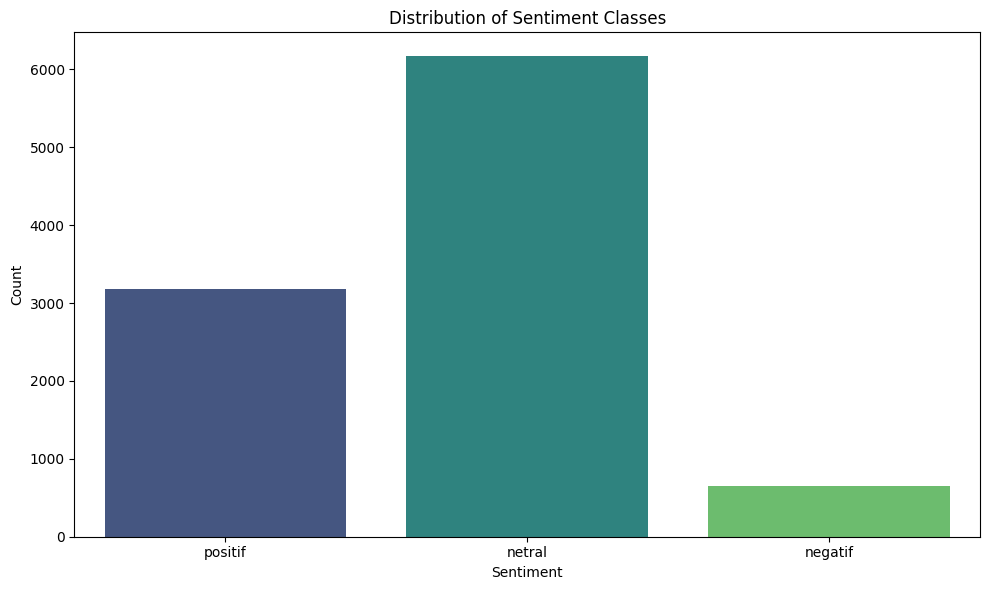

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Label Sentimen', data=df, palette='viridis', hue='Label Sentimen', legend=False)
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
print(df.columns)  # Cek daftar kolom dalam dataframe

Index(['userName', 'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion',
       'at', 'replyContent', 'Label Sentimen', 'Processed_Text'],
      dtype='object')


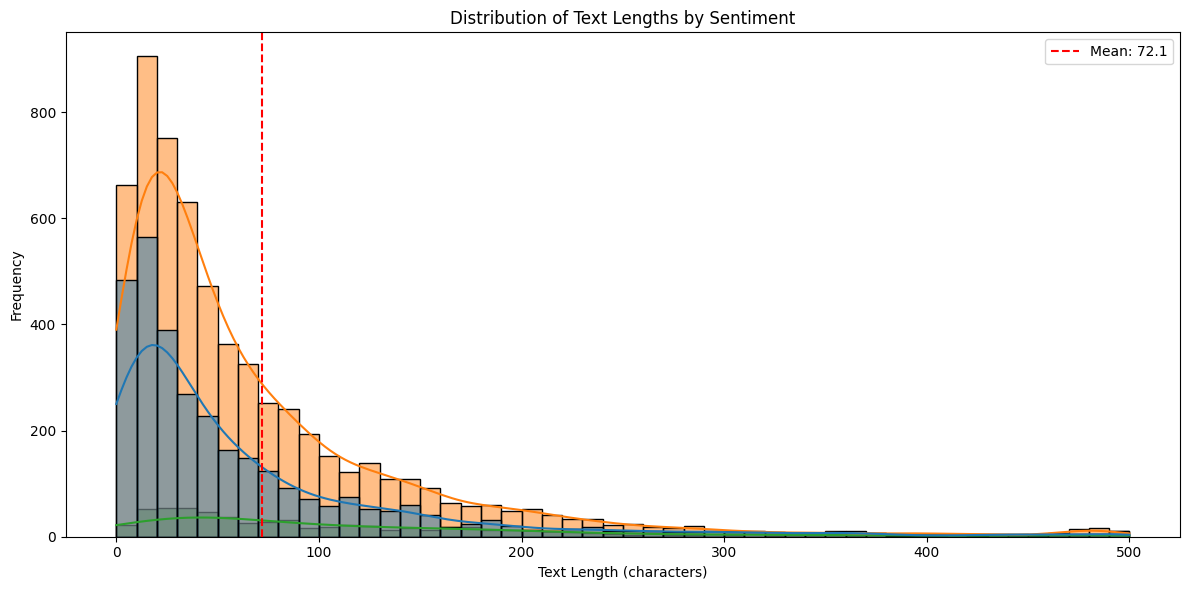

In [15]:
df['text_length'] = df['Processed_Text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='Label Sentimen', bins=50, kde=True)
plt.title('Distribution of Text Lengths by Sentiment')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.axvline(x=df['text_length'].mean(), color='r', linestyle='--', label=f'Mean: {df["text_length"].mean():.1f}')
plt.legend()
plt.tight_layout()
plt.show()

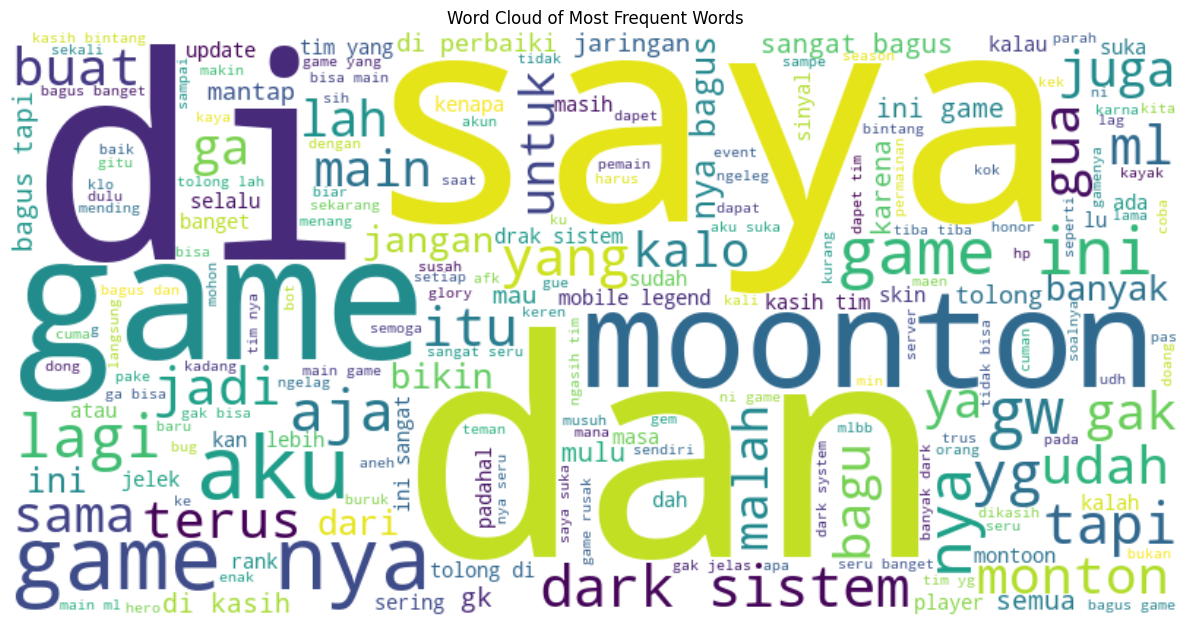

In [16]:
all_text = ' '.join(df['Processed_Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.tight_layout()
plt.show()

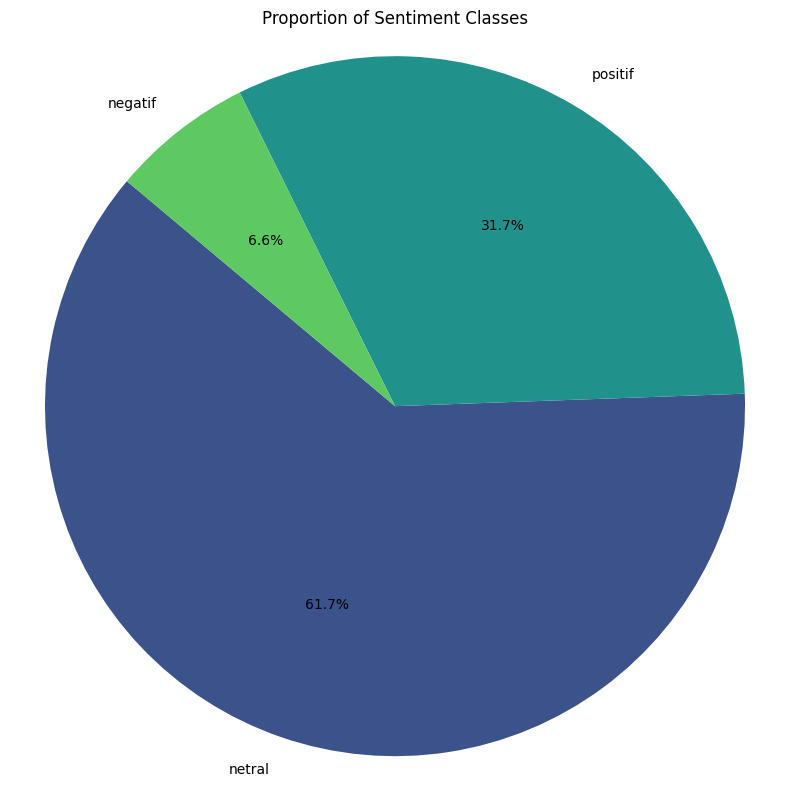

In [17]:
sentiment_proportions = df['Label Sentimen'].value_counts(normalize=True)

plt.figure(figsize=(8, 8))
plt.pie(sentiment_proportions, labels=sentiment_proportions.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', n_colors=3))
plt.title('Proportion of Sentiment Classes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

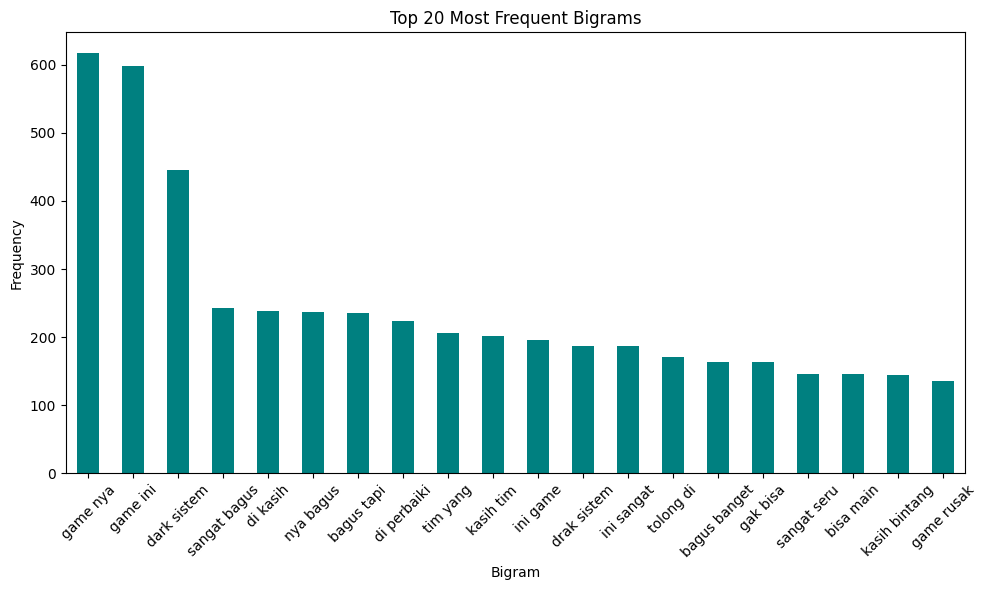

In [18]:
# Extract bigrams using CountVectorizer
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['Processed_Text'])
bigram_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Plot the top 20 most frequent bigrams
bigram_freq = bigram_df.sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 6))
bigram_freq.plot(kind='bar', color='teal')
plt.title('Top 20 Most Frequent Bigrams')
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Feature Extraction**

In [19]:
# Define Features and Labels
X = df['Processed_Text']
y = df['Label Sentimen'].map({'positif': 2, 'netral': 1, 'negatif': 0})

# --- TF-IDF Vectorization for traditional ML ---
print("Creating TF-IDF features...")

# TF-IDF Vectorization (gunakan sparse matrix untuk efisiensi memori)
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)  # Matriks sparse
print(f"TF-IDF feature shape: {X_tfidf.shape}")

# --- Word2Vec Embeddings for Traditional ML ---
from gensim.models import Word2Vec
print("\nCreating Word2Vec features...")
tokenized_text = [text.split() for text in X]  # Pastikan teks sudah ditokenisasi
w2v_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)
print(f"Word2Vec vocabulary size: {len(w2v_model.wv.key_to_index)} words")

# --- LSTM Sequence Preparation ---
print("\nCreating sequence features for deep learning...")
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=100)  # Padding untuk LSTM
print(f"Sequence feature shape: {X_pad.shape}")

# Display vocabulary size
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)} words")

Creating TF-IDF features...
TF-IDF feature shape: (10000, 5000)

Creating Word2Vec features...
Word2Vec vocabulary size: 10804 words

Creating sequence features for deep learning...
Sequence feature shape: (10000, 100)
Vocabulary size: 10804 words


## **Eksperimen Modelling**

### **Word2Vec + Random Forest (Split 80:20)**

In [20]:
# Tokenization
tokenized_texts = [text.split() for text in df["Processed_Text"]]

# Fungsi untuk mendapatkan vektor rata-rata dari setiap teks
def get_average_word2vec(tokens, model, vector_size):
    feature_vector = np.zeros(vector_size, dtype="float32")
    word_count = 0
    for word in tokens:
        if word in model.wv:
            feature_vector += model.wv[word]
            word_count += 1
    if word_count > 0:
        feature_vector /= word_count  # Rata-rata vektor
    return feature_vector

# Konversi semua teks ke vektor Word2Vec
X = np.array([get_average_word2vec(tokens, w2v_model, 100) for tokens in tokenized_texts])
y = df["Label Sentimen"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42, stratify=y)

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluasi
train_accuracy = accuracy_score(y_train, rf_model.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Training Accuracy: {train_accuracy:.4f}")
print(f"Random Forest Test Accuracy: {test_accuracy:.4f}")

Random Forest Training Accuracy: 1.0000
Random Forest Test Accuracy: 0.8086


### **TFIDF + SVM (80:20 Split)**

In [21]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# --- Train SVM Model ---
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# --- Evaluate SVM Model on Training Data ---
y_train_pred = svm_model.predict(X_train)
svm_train_acc = accuracy_score(y_train, y_train_pred)
print(f"SVM Training Accuracy: {svm_train_acc:.4f}")

# --- Evaluate SVM Model on Test Data ---
y_test_pred = svm_model.predict(X_test)
svm_test_acc = accuracy_score(y_test, y_test_pred)
print(f"SVM Test Accuracy: {svm_test_acc:.4f}")

# Display detailed classification report
print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_test_pred, target_names=['Negatif', 'Netral', 'Positif']))

SVM Training Accuracy: 0.9921
SVM Test Accuracy: 0.9640

Classification Report (Test Data):
              precision    recall  f1-score   support

     Negatif       0.98      0.77      0.86       137
      Netral       0.95      0.99      0.97      1230
     Positif       0.99      0.95      0.97       633

    accuracy                           0.96      2000
   macro avg       0.97      0.90      0.93      2000
weighted avg       0.96      0.96      0.96      2000



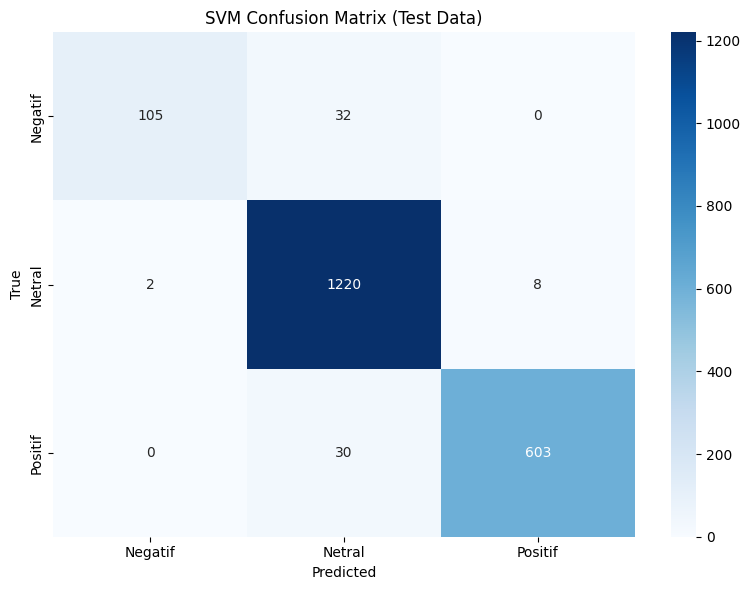

In [22]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Netral', 'Positif'], 
            yticklabels=['Negatif', 'Netral', 'Positif'])
plt.title('SVM Confusion Matrix (Test Data)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

### **Word Embedding + LSTM (80:20 Split)**

In [23]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Konversi y_encoded menjadi numpy array dengan dtype int32
y = np.array(y_encoded, dtype=np.int32)

# Split data
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# Build LSTM model
print("\nBuilding LSTM model...")
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')
])
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("LSTM model architecture:")
lstm_model.summary()

# Train LSTM
print("\nTraining LSTM model...")
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)
print("LSTM model training completed.")

# Evaluate
print("\nEvaluating LSTM model...")

train_acc = history.history['accuracy'][-1]  # Akurasi di epoch terakhir
val_acc = history.history['val_accuracy'][-1]  # Akurasi validasi di epoch terakhir
lstm_loss, lstm_acc = lstm_model.evaluate(X_test_lstm, y_test_lstm, verbose=0)

# Tampilkan hasil
print(f"\n✅ LSTM Training Accuracy: {train_acc:.4f}")
print(f"✅ LSTM Validation Accuracy: {val_acc:.4f}")
print(f"✅ LSTM Test Accuracy: {lstm_acc:.4f}")

y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
print("\nClassification Report:")
print(classification_report(y_test_lstm, y_pred_lstm, target_names=['negatif', 'netral', 'positif']))


Building LSTM model...
LSTM model architecture:


d:\Coolyeah\Dicoding\Submission_Dicoding\ml_ops\envs\ml-pengembangan\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.6373 - loss: 0.8167 - val_accuracy: 0.8731 - val_loss: 0.3883
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.9073 - loss: 0.2770 - val_accuracy: 0.9269 - val_loss: 0.2287
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.9664 - loss: 0.1135 - val_accuracy: 0.9619 - val_loss: 0.1054
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.9848 - loss: 0.0487 - val_accuracy: 0.9706 - val_loss: 0.0954
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9848 - loss: 0.0463 - val_accuracy: 0.9794 - val_loss: 0.0600
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.9928 - loss: 0.0270 - val_accuracy: 0.9856 - val_loss: 0.0498
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.9948 - loss: 0.0243 - val_accuracy: 0.9887 - val_loss: 0.0410
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 

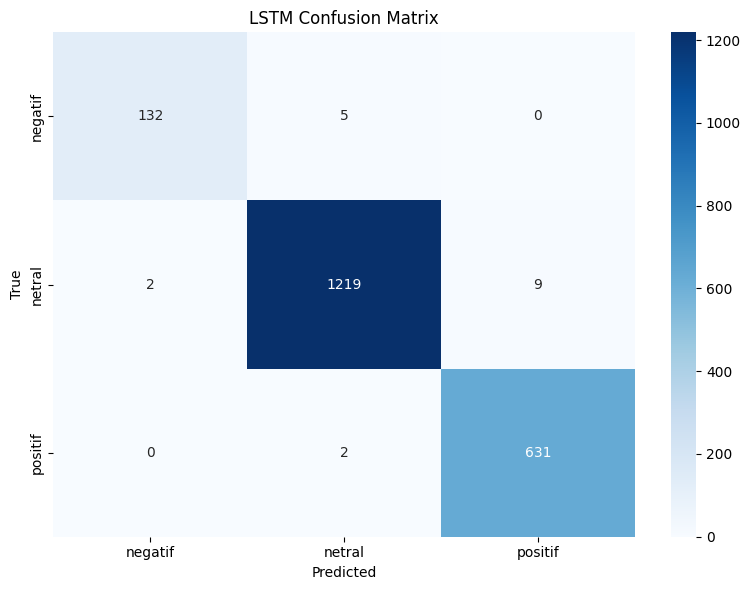

In [24]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_lstm, y_pred_lstm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negatif', 'netral', 'positif'], 
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## **Comparisan Model Performance**

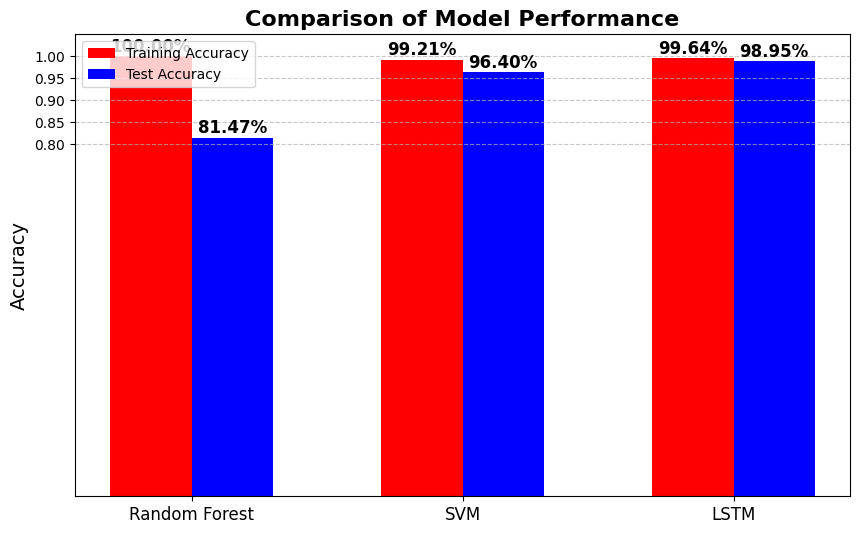

In [25]:
# Data Akurasi dari Hasil Eksperimen
models = ['Random Forest', 'SVM', 'LSTM']
train_acc = [1.0000, 0.9921, 0.9964]  # Training Accuracy
test_acc = [0.8147, 0.9640, 0.9895]   # Test Accuracy

# Warna untuk visualisasi
colors = ['red', 'blue', 'green']

# Membuat plot
plt.figure(figsize=(10, 6))
x = np.arange(len(models))
width = 0.3

# Bar plot
plt.bar(x - width/2, train_acc, width, label='Training Accuracy', color=colors[0])
plt.bar(x + width/2, test_acc, width, label='Test Accuracy', color=colors[1])

# Menambahkan teks di atas bar
for i in range(len(models)):
    plt.text(i - width/2, train_acc[i] + 0.01, f"{train_acc[i]*100:.2f}%", ha='center', fontsize=12, fontweight='bold')
    plt.text(i + width/2, test_acc[i] + 0.01, f"{test_acc[i]*100:.2f}%", ha='center', fontsize=12, fontweight='bold')

# Labeling
plt.xticks(x, models, fontsize=12)
plt.yticks(np.arange(0.8, 1.05, 0.05))
plt.ylabel('Accuracy', fontsize=14)
plt.title('Comparison of Model Performance', fontsize=16, fontweight='bold')
plt.legend()

# Grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

## **Inference Model**

In [33]:
os.makedirs('models', exist_ok=True)

joblib.dump(tokenizer, 'models/tokenizer.pkl')
lstm_model.save('models/lstm_model.h5')
joblib.dump(tfidf, 'models/tfidf_vectorizer.pkl')
joblib.dump(svm_model, 'models/svm_model.pkl')
joblib.dump(rf_model, 'models/rf_model.pkl')
joblib.dump(w2v_model, 'models/word2vec_model.pkl')
joblib.dump(label_encoder, 'models/label_encoder.pkl')

print("🔥 Semua model berhasil disimpan di folder 'models'! 🚀")

🔥 Semua model berhasil disimpan di folder 'models'! 🚀


In [34]:
tokenizer = joblib.load('models/tokenizer.pkl')
lstm_model = load_model('models/lstm_model.h5')
tfidf = joblib.load('models/tfidf_vectorizer.pkl')
svm_model = joblib.load('models/svm_model.pkl')
rf_model = joblib.load('models/rf_model.pkl')
w2v_model = joblib.load('models/word2vec_model.pkl')
label_encoder = joblib.load('models/label_encoder.pkl')

label_map = {idx: label for idx, label in enumerate(label_encoder.classes_)}
print("🔥 Semua model berhasil di-load dari folder 'models'! 🚀")

🔥 Semua model berhasil di-load dari folder 'models'! 🚀


In [35]:
def predict_sentiment(text, model_type):
    """
    🔥 Memprediksi sentimen teks berdasarkan model yang dipilih (LSTM, SVM, RF).
    """
    pred_label = None  # 🔥 Pastikan selalu ada nilai default
    confidence = 0.0  

    if model_type == 'lstm':
        sequence = tokenizer.texts_to_sequences([text])
        padded = pad_sequences(sequence, maxlen=100)
        probs = lstm_model.predict(padded)
        pred_label = ['negatif', 'netral', 'positif'][np.argmax(probs)]  # 🔥 Mapping Index ke Label
        confidence = float(np.max(probs))  

    elif model_type == 'svm':
        text_tfidf = tfidf.transform([text])  
        pred_label = svm_model.predict(text_tfidf)[0] 

        confidence_score = svm_model.predict_proba(text_tfidf)[0] 
        confidence = float(max(confidence_score)) 

    elif model_type == 'rf':
        tokens = text.split()  
        text_w2v = get_average_word2vec(tokens, w2v_model, 100)  
        text_w2v = text_w2v.reshape(1, -1)  
        pred_label = rf_model.predict(text_w2v)[0]  
        confidence = float(max(rf_model.predict_proba(text_w2v)[0]))  

    else:
        raise ValueError("Model type harus 'lstm', 'svm', atau 'rf'")

    return pred_label, confidence

In [41]:
# 🔥 Contoh Prediksi
sample_reviews = [
    "Main kayak ayam, mati mulu ga ada kontribusi!",
    "Tim beban semua, poke semua!",
    "Woi poke, otaknya dimana sih?!",
    "Grafik lumayan, gameplay standar, nothing special.",
    "Game-nya lumayan buat killing time, tapi nggak bikin nagih.",
    "Eventnya oke lah, bagus saya suka.",
    "Server lancar.",
    "Meta sekarang agak aneh, tapi masih bisa dinikmati.",
    "Controlnya cukup enak, cuma butuh waktu buat terbiasa.",
    "Update terbaru ada perubahan, masih adaptasi dulu.",
]

results = []
for review in sample_reviews:
    lstm_pred, lstm_conf = predict_sentiment(review, 'lstm')
    svm_pred, svm_conf = predict_sentiment(review, 'svm')
    rf_pred, rf_conf = predict_sentiment(review, 'rf')
    results.append({
        'Review': review,
        'LSTM Prediction': lstm_pred,
        'LSTM Confidence': f"{lstm_conf:.4f}",
        'SVM Prediction': svm_pred,
        'SVM Confidence': f"{svm_conf:.4f}",
        'RF Prediction': rf_pred,
        'RF Confidence': f"{rf_conf:.4f}"
    })

import pandas as pd
display(pd.DataFrame(results))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


,Review,LSTM Prediction,LSTM Confidence,SVM Prediction,SVM Confidence,RF Prediction,RF Confidence
0,"Main kayak ayam, mati mulu ga ada kontribusi!",negatif,0.8461,netral,0.5246,netral,0.8500
1,"Tim beban semua, poke semua!",negatif,0.9931,negatif,0.9987,netral,0.9900
2,"Woi poke, otaknya dimana sih?!",negatif,0.8130,negatif,0.9978,netral,0.9200
3,"Grafik lumayan, gameplay standar, nothing spec...",netral,0.9990,netral,0.9370,netral,0.9000
4,"Game-nya lumayan buat killing time, tapi nggak...",netral,0.9992,netral,0.9882,positif,0.7100
5,"Eventnya oke lah, bagus saya suka.",positif,1.0000,positif,1.0000,positif,0.8300
6,Server lancar.,positif,0.9992,positif,1.0000,netral,1.0000
7,"Meta sekarang agak aneh, tapi masih bisa dinik...",netral,1.0000,netral,0.9967,netral,0.5200
8,"Controlnya cukup enak, cuma butuh waktu buat t...",netral,0.9982,netral,0.9830,netral,0.8000
9,"Update terbaru ada perubahan, masih adaptasi d...",netral,0.9998,netral,0.9027,netral,0.4700
